In [37]:
# https://stackoverflow.com/questions/74832296/typeerror-string-indices-must-be-integers-when-getting-data-of-a-stock-from-y

import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date, datetime
current_date = datetime.today().strftime('%Y-%m-%d')
import pandas_datareader
from pandas_datareader import data as pdr
import yfinance as yf
import datetime
yf.pdr_override()

In [38]:
startdate = ['2012', '01', '12']
today = str(date.today()).split('-')
#Declares payday which calls datetime.date() and takes three (3) integer arguments: current year (int(get_today[0])), current month (int(get_today[1]))
startdate= datetime.date(int(startdate[0]), int(startdate[1]), int(today[2]))
today = datetime.date(int(today[0]), int(today[1]), int(today[2]))
#Declares chqday which uses timedelta and passes an integer, (10)
chqday = datetime.timedelta(1)
#Declares n_payday which subtracts payday from chqday
yesterday = today - chqday
#printing the payday
print("startdate:",startdate)
print("yesterday:",yesterday)
print("today:",today)

startdate: 2012-01-18
yesterday: 2023-02-17
today: 2023-02-18


In [39]:
# Get stock quote
y_symbols = 'NWG.L'

startdate = startdate
today = str(current_date).split('-')
enddate = current_date
df = pdr.get_data_yahoo(y_symbols, start=startdate, end=enddate)
print(df.shape)
df


[*********************100%***********************]  1 of 1 completed
(2801, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-18,263.846100,270.178406,259.322998,267.507599,203.131760,10755480
2012-01-19,268.046112,291.964600,268.024597,291.415314,221.286087,18084515
2012-01-20,290.769196,302.033813,288.076904,295.507599,224.393600,17905914
2012-01-23,295.830688,306.944611,292.061493,303.046112,230.117950,12484833
2012-01-24,302.722992,302.722992,284.092285,291.307587,221.204300,11582578
...,...,...,...,...,...,...
2023-02-13,305.700012,306.700012,303.299988,303.799988,303.799988,14339700
2023-02-14,305.000000,307.100006,303.299988,305.000000,305.000000,19534499
2023-02-15,298.000000,301.899994,293.899994,300.799988,300.799988,21540348


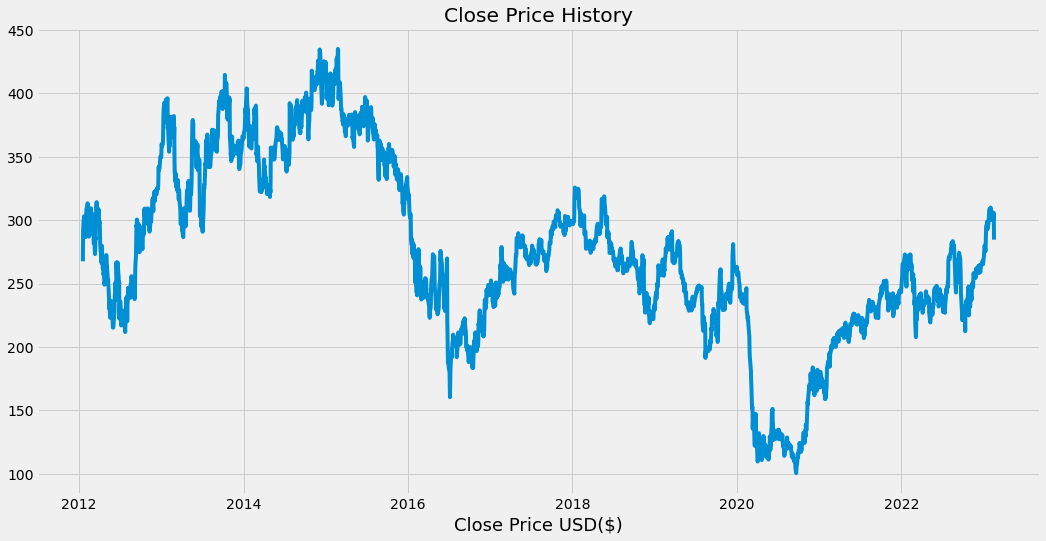

In [40]:
# Visualise the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.xlabel('Close Price USD($)', fontsize=18)
plt.show()


In [41]:
# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

# Convert dataframe to numpy array
dataset = data.values

# Compute the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.75)

In [42]:
# Scale data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.4993237 ],
       [0.57080292],
       [0.58303803],
       ...,
       [0.5988612 ],
       [0.61321228],
       [0.55042653]])

In [43]:
# Create training dataset
train_data = scaled_data[0:training_data_len,:]

# Split data into x_train and y_train datasets
x_train = [] # independent
y_train = [] # dependent 

for i in range (60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()



[array([0.4993237 , 0.57080292, 0.58303803, 0.60557665, 0.57048084,
       0.56082175, 0.59044372, 0.59269748, 0.56114375, 0.55663606,
       0.59269748, 0.61394805, 0.62328551, 0.62650524, 0.62940288,
       0.6361646 , 0.62714922, 0.59817123, 0.6042886 , 0.55760176,
       0.56854917, 0.56082175, 0.58818979, 0.6165238 , 0.60783032,
       0.57949631, 0.62425148, 0.61813375, 0.5991372 , 0.61137231,
       0.59849322, 0.59301947, 0.60235693, 0.58110636, 0.54214683,
       0.54182484, 0.54794258, 0.5431129 , 0.51638857, 0.52894576,
       0.55470402, 0.55180629, 0.60557665, 0.63874034, 0.62135348,
       0.61781176, 0.59784915, 0.60203494, 0.59301947, 0.62264153,
       0.62070949, 0.59559521, 0.58947775, 0.59301947, 0.56532944,
       0.53989317, 0.5308777 , 0.49545999, 0.51284685, 0.53538548])]
[0.5060854122415548]



In [44]:
# Convert the x_train and y_train to numpy arrays to be used to train the LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data - LSTM expects 3D
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [45]:
# Build LSTM model 
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1))) # return_sequences=True as we have layer after, input_shape=(60 ,1) - shape of training data.
model.add(LSTM(50, return_sequences=False)) # Increasing the depth increases the capacity of the model. 
model.add(Dense(25)) # Dense layer is deeply connected layer from its preceding layer which works for changing the dimension of the output by performing matrix vector multiplication
model.add(Dense(1))

# model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1))) # More layers = longer training, may overfit
# model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dense(units=1)) # Prediction of the next closing price

In [46]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [47]:
model.fit(x_train, y_train, batch_size=32, epochs=1)

2023-02-18 21:03:33.084073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-18 21:03:33.615962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-18 21:03:33.833945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-18 21:03:34.055447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-18 21:03:34.367206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 8s 58ms/step - loss: 0.0220


In [57]:
#  Create the testing dataset
test_data = scaled_data[training_data_len-60:, :]

# Create the datasets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)): #
    x_test.append(test_data[i-60:i, 0])

# print(x_test)


[array([0.38566563, 0.37246451, 0.36570279, 0.36280506, 0.36827877,
       0.35668732, 0.33624191, 0.32770934, 0.32110875, 0.29003787,
       0.27474417, 0.25494242, 0.24834184, 0.24125845, 0.217271  ,
       0.20584069, 0.15319724, 0.15609493, 0.15545122, 0.10425664,
       0.1203555 , 0.10667148, 0.12373636, 0.11085723, 0.09314832,
       0.06594119, 0.06368717, 0.0867086 , 0.13983522, 0.12615124,
       0.08638693, 0.07753234, 0.06304348, 0.04404659, 0.03583631,
       0.02714287, 0.04420775, 0.07157576, 0.0707709 , 0.09395321,
       0.06964404, 0.03535316, 0.0335823 , 0.04147089, 0.04066574,
       0.03052346, 0.03664117, 0.04227574, 0.03631918, 0.04565662,
       0.06996576, 0.08735263, 0.0554769 , 0.06417034, 0.05418889,
       0.06256031, 0.04791032, 0.06690719, 0.05515489, 0.05402804]), array([0.37246451, 0.36570279, 0.36280506, 0.36827877, 0.35668732,
       0.33624191, 0.32770934, 0.32110875, 0.29003787, 0.27474417,
       0.25494242, 0.24834184, 0.24125845, 0.217271  , 0.20

In [49]:
# Convert data to numpy array 
x_test = np.array(x_test)
print(x_test.shape)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)
print(x_test)

(700, 60)
(700, 60, 1)
[[[0.38566563]
  [0.37246451]
  [0.36570279]
  ...
  [0.06690719]
  [0.05515489]
  [0.05402804]]

 [[0.37246451]
  [0.36570279]
  [0.36280506]
  ...
  [0.05515489]
  [0.05402804]
  [0.04082689]]

 [[0.36570279]
  [0.36280506]
  [0.36827877]
  ...
  [0.05402804]
  [0.04082689]
  [0.03825117]]

 ...

 [[0.4711969 ]
  [0.4637224 ]
  [0.46073261]
  ...
  [0.60992349]
  [0.60783059]
  [0.61141838]]

 [[0.4637224 ]
  [0.46073261]
  [0.45983566]
  ...
  [0.60783059]
  [0.61141838]
  [0.5988612 ]]

 [[0.46073261]
  [0.45983566]
  [0.4729908 ]
  ...
  [0.61141838]
  [0.5988612 ]
  [0.61321228]]]


In [50]:
# Get models predicted price values
predictions = model.predict(x_test)
print(predictions)


2023-02-18 21:03:39.801879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-18 21:03:39.939267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-18 21:03:40.064648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.13058372]
 [0.13034476]
 [0.12962987]
 [0.12852497]
 [0.12744166]
 [0.1263873 ]
 [0.1254111 ]
 [0.12418689]
 [0.12292694]
 [0.1225074 ]
 [0.12345068]
 [0.12513556]
 [0.1265328 ]
 [0.12814799]
 [0.13035344]
 [0.13337901]
 [0.1369928 ]
 [0.14193909]
 [0.14794359]
 [0.15357673]
 [0.15846023]
 [0.1614825 ]
 [0.16317424]
 [0.1637998 ]
 [0.16427611]
 [0.16446407]
 [0.16442926]
 [0.1641697 ]
 [0.16365004]
 [0.16327539]
 [0.16263881]
 [0.16189751]
 [0.16094181]
 [0.16014089]
 [0.15952076]
 [0.1588434 ]
 [0.15870422]
 [0.15863818]
 [0.15895316]
 [0.15919502]
 [0.15925634]
 [0.15892863]
 [0.15867579]
 [0.15858674]
 [0.15849152]
 [0.1584229 ]
 [0.15842003]
 [0.15832978]
 [0.15806715]
 [0.15787931]
 [0.15770581]
 [0.15715456]
 [0.15616861]
 [0.15461755]
 [0.15294692]
 [0.15097976]
 [0.1483369 ]
 [0.14532427]
 [0.14266123]
 [0.14049189]
 [0.1387179 ]
 [0.13729326]
 [0.13604443]
 [0.13530871]
 [0.13547799]
 [0.13628529]
 [0.1370629 ]
 [0.1378797 ]
 [0.13849005]
 [0.13875127]
 [0.13905266]
 [0.13

In [51]:
predictions = scaler.inverse_transform(predictions) # unscale values. 
# Want predictions to contain the same values as our y_test dataset
# Getting predictions based off of x_test dataset 

# Evaluate model with RMSE
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
rmse 

14.601180264190718

/var/folders/5l/m4mgg0s9311963f49gn6z3pc0000gn/T/ipykernel_27972/3205351450.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


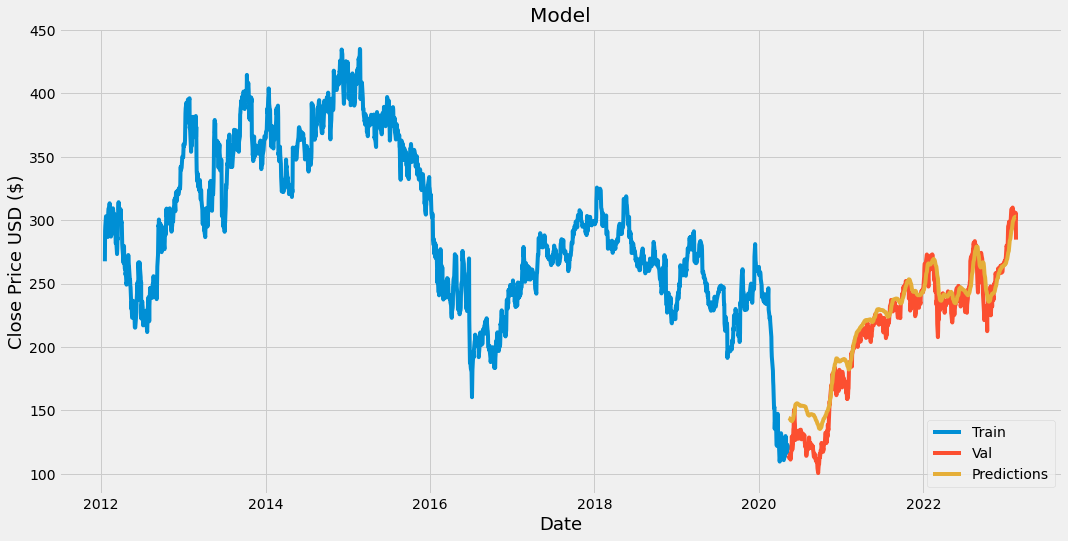

In [52]:
# Plot the data
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions

# Visulise the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')



In [53]:
# Show the valid price and predicted prices
validation

,Close,Predictions
Date,,
2020-05-13,114.153801,144.174835
2020-05-14,113.292297,144.094910
2020-05-15,112.430702,143.855804
2020-05-18,115.230698,143.486252
2020-05-19,114.853798,143.123917
...,...,...
2023-02-13,303.799988,302.420685
2023-02-14,305.000000,302.589325
2023-02-15,300.799988,302.719421


In [54]:
# Predict future stock price
quote = pdr.get_data_yahoo(y_symbols, start=startdate, end='2023-02-17')

new_df = quote.filter(['Close'])

# Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
# Scale the data to be values between 0 and 1 
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)

# Convert to numpy array
X_test = np.array(X_test)
# Reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# print(X_test)

# Get predicted scaled price
pred_price = model.predict(X_test)

# Undo scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)
# 16 - [[157.24701]]
# 17 - [[157.2469]]

[*********************100%***********************]  1 of 1 completed
[[302.66864]]


In [55]:
# Get the quote
quote_2 = pdr.get_data_yahoo(y_symbols, start=enddate, end=enddate)


[*********************100%***********************]  1 of 1 completed
